Realizado por: Frank Hernandez y Sara Peña

Librerías

In [1]:
pip install pandas numpy scikit-learn tensorflow

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

Carga y limpieza de los datos

In [3]:
#Cargamos el dataset en chunks para evitar errores de memoria
chunk_size = 100000  #Cantidad de filas por chunk
chunks = pd.read_csv('accepted_2007_to_2018Q4.csv', chunksize=chunk_size)
#Variables útiles
variables_utiles = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'purpose', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
    'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'total_acc', 'revol_bal', 'revol_util',
    'application_type', 'acc_now_delinq', 'pub_rec_bankruptcies', 'mort_acc',
    'num_tl_90g_dpd_24m', 'loan_status', 'total_pymnt_inv', 'chargeoff_within_12_mths'
]
#Combinamos los chunks en un solo DataFrame con solo las variables útiles
df = pd.concat(chunk[variables_utiles] for chunk in chunks)

<ipython-input-3-0aa2658dc392>:14: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(chunk[variables_utiles] for chunk in chunks)
<ipython-input-3-0aa2658dc392>:14: DtypeWarning: Columns (19,59) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(chunk[variables_utiles] for chunk in chunks)


Conociendo la variable objetivo y sus opciones

In [4]:
print(df['loan_status'].value_counts())

loan_status
Fully Paid            102811
Charged Off            25509
Current                16498
Late (31-120 days)       594
In Grace Period          265
Late (16-30 days)        106
Default                    1
Name: count, dtype: int64


In [5]:
print(df['loan_status'].unique())

['Fully Paid' 'Current' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)' 'Default']


Preprocesamiento de la variable objetivo

In [6]:
# 1. Guardar el estado original de los préstamos
df['loan_status_original'] = df['loan_status']

# 2. Convertir a variable binaria: 1 = impago, 0 = pagado
df['loan_status'] = df['loan_status_original'].apply(
    lambda x: 1 if x in ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)'] else 0
)



Preprocesamiento de las variables

In [7]:
#Variables numéricas y categóricas
vars_numericas = df.select_dtypes(include=['int64', 'float64']).drop('loan_status', axis=1).columns.tolist()
vars_categoricas = df.select_dtypes(include='object').columns.tolist()

#Imputación simple
df[vars_numericas] = df[vars_numericas].fillna(df[vars_numericas].median())
df[vars_categoricas] = df[vars_categoricas].fillna('Desconocido')

#Codificación
df = pd.get_dummies(df, columns=vars_categoricas, drop_first=True)

#Escalar en chunks
scaler = StandardScaler()
X_chunks = []
y_chunks = []

chunk_size = 100000  #Define un tamaño de chunk adecuado
for start in range(0, len(df), chunk_size):
	end = start + chunk_size
	chunk = df.iloc[start:end]
	X_chunk = scaler.fit_transform(chunk.drop('loan_status', axis=1))
	y_chunk = chunk['loan_status'].values
	X_chunks.append(X_chunk)
	y_chunks.append(y_chunk)

#Concatenar los resultados
X = np.vstack(X_chunks)
y = np.concatenate(y_chunks)

Dividir entre datos de entrenamiento y los de prueba

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creación de la red neuronal

In [9]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,321 (32.50 KB)

 Trainable params: 8,321 (32.50 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento de la red

In [22]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9999 - loss: 2.7225e-04 - val_accuracy: 1.0000 - val_loss: 6.7402e-09
Epoch 2/20
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9999 - loss: 5.8130e-04 - val_accuracy: 1.0000 - val_loss: 5.1910e-11
Epoch 3/20
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 1.0000 - loss: 1.4628e-04 - val_accuracy: 1.0000 - val_loss: 5.6694e-06
Epoch 4/20
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 2.6540e-04 - val_accuracy: 1.0000 - val_loss: 1.9453e-10
Epoch 5/20
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9999 - loss: 2.0471e-04 - val_accuracy: 1.0000 - val_loss: 4.9954e-10
Epoch 6/20
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 4.7467e-09
Epoch 7/20
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 1.0000 - loss: 1.5043e-04 - val_accuracy: 1.0000 - val_loss: 6.1964e-10
Epoch 8/20
1458/1458 ━━━━━━━━━━━━━━━━━

Evaluación del modelo

In [23]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

912/912 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[[23915     0]
 [    0  5242]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23915
           1       1.00      1.00      1.00      5242

    accuracy                           1.00     29157
   macro avg       1.00      1.00      1.00     29157
weighted avg       1.00      1.00      1.00     29157



Probabilidad de impago

In [24]:
probabilidad_impago = model.predict(X_test)
print(probabilidad_impago[:10])  #Probabilidad para los primeros 10 casos
# Crear nombres genéricos para las columnas de X_test
column_names = [f'feature_{i}' for i in range(X_test.shape[1])]
df_test = pd.DataFrame(X_test, columns=column_names)
# Añadiendo las columnas de probabilidad y estado del préstamo al DataFrame
df_test['probabilidad_impago'] = probabilidad_impago.flatten()
df_test['loan_status'] = y_test
print(df_test.columns)


912/912 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
[[8.16463622e-36]
 [1.89806356e-31]
 [1.02128935e-35]
 [1.12991623e-36]
 [2.21542677e-36]
 [6.85845764e-32]
 [1.19065458e-38]
 [8.89344048e-38]
 [8.45258634e-29]
 [1.71157097e-36]]
Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',
       'feature_50

Respuestas a las preguntas del documento

Considere el rendimiento de una inversión correspondiente al retorno anual de la inversión.

In [26]:
# Paso 1: Reconstruir 'term' a partir de la variable dummy 'term_ 60 months'
df['term'] = df['term_ 60 months'].apply(lambda x: '60 months' if x == 1 else '36 months')

# Paso 2: Calcular retorno bruto
df['retorno'] = (df['total_pymnt_inv'] / df['loan_amnt']) - 1

# Paso 3: Convertir 'term' a años
df['term_years'] = df['term'].apply(lambda x: int(x.split()[0])) / 12

# Paso 4: Calcular retorno anualizado
df['retorno_anual'] = ((df['retorno'] + 1) ** (1 / df['term_years'])) - 1

# Paso 5: Ver retorno anual promedio
print("Retorno anual promedio:", df['retorno_anual'].mean())


Retorno anual promedio: 0.0003733111261247552


¿Los préstamos cancelados, generaron algún tipo de retorno?

In [56]:
# Filtrar los préstamos "Charged Off"
charged_off = df[df['loan_status'] == 'Charged Off']

# Verificar si generaron algún pago
pagos_realizados = charged_off[charged_off['total_pymnt_inv'] > 0]

# Estadísticas de los pagos realizados (si los hay)
print("Total Charged Off:", len(charged_off))
print("Con algún pago:", len(pagos_realizados))
print(pagos_realizados['total_pymnt_inv'].describe())


Total Charged Off: 0
Con algún pago: 0
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: total_pymnt_inv, dtype: float64


¿Cómo se explica la variación de los retornos de los créditos cancelados con respecto a la categoría del crédito?

In [28]:
print(cancelados.columns)


Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq',
       ...
       'loan_status_original_Late (31-120 days)', 'ingreso_mensual',
       'cuota_ingreso', 'empleo_estable', 'rango_fico_promedio', 'term',
       'retorno', 'term_years', 'retorno_anual', 'grade'],
      dtype='object', length=106)


<ipython-input-29-e4c27af9765c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=retorno_por_categoria.index, y=retorno_por_categoria.values, palette='viridis')


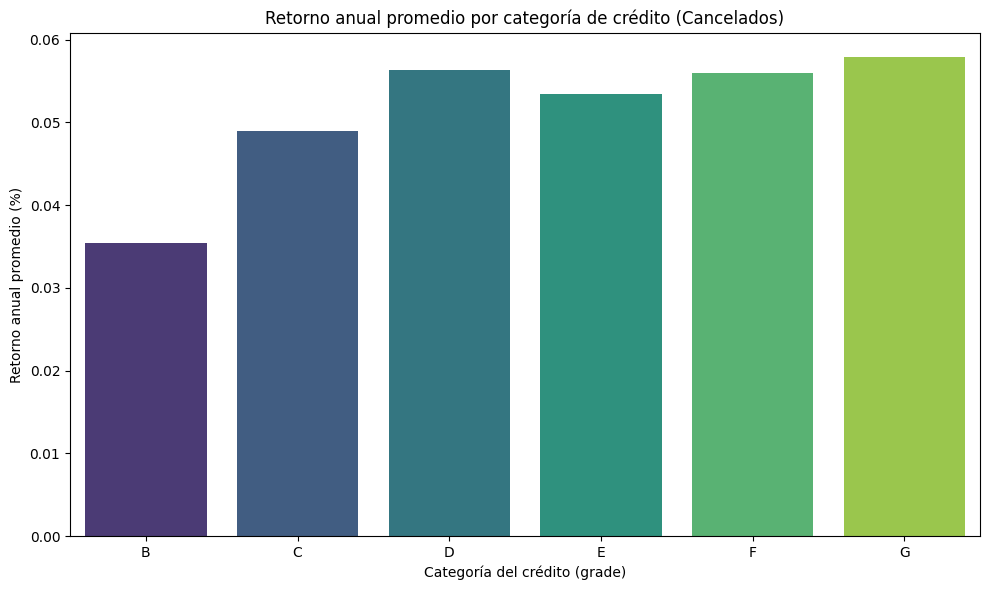

In [29]:
# Paso 1: Crear la columna 'grade'
grade_cols = [col for col in df.columns if col.startswith('grade_') and len(col) == 7]
df['grade'] = df[grade_cols].idxmax(axis=1).str[-1]

# Paso 2: Filtrar los préstamos cancelados
cancelados = df[df['loan_status_original_Fully Paid'] == 1].copy()

# Paso 3: Calcular el número de años (3 si no es 60 meses)
cancelados['term_years'] = cancelados['term_ 60 months'].apply(lambda x: 5 if x == 1 else 3)

# Paso 4: Calcular retorno anual compuesto
cancelados['retorno_anual'] = (cancelados['total_pymnt_inv'] / cancelados['loan_amnt']) ** (1 / cancelados['term_years']) - 1

# Paso 5: Agrupar y visualizar
retorno_por_categoria = cancelados.groupby('grade')['retorno_anual'].mean().sort_index()

plt.figure(figsize=(10,6))
sns.barplot(x=retorno_por_categoria.index, y=retorno_por_categoria.values, palette='viridis')
plt.title('Retorno anual promedio por categoría de crédito (Cancelados)')
plt.xlabel('Categoría del crédito (grade)')
plt.ylabel('Retorno anual promedio (%)')
plt.tight_layout()
plt.show()


¿Existe diferencia entre el promedio de retorno de los créditos y la tasa de interés promedio? ¿Qué significa esta diferencia?

In [30]:
# Calcular promedios
retorno_promedio = df['retorno_anual'].mean()
tasa_promedio = df['int_rate'].mean()
diferencia = tasa_promedio - retorno_promedio

# Mostrar resultados
print("Tasa de interés promedio:", tasa_promedio)
print("Retorno anual promedio:", retorno_promedio)
print("Diferencia:", diferencia)

Tasa de interés promedio: 12.271014308840476
Retorno anual promedio: 0.0003733111261247552
Diferencia: 12.27064099771435


¿Asumiendo el rol del inversionista, en cuáles créditos preferiría invertir y cuáles son las razones que motivan la decisión?

In [31]:
# Cálculos previos necesarios
df['ingreso_mensual'] = df['annual_inc'] / 12
df['cuota_ingreso'] = df['installment'] / df['ingreso_mensual']
df['rango_fico_promedio'] = (df['fico_range_low'] + df['fico_range_high']) / 2

# Crear columna de empleo estable con las variables dummies que ya tienes
df['empleo_estable'] = (
    df[['emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
        'emp_length_8 years', 'emp_length_9 years', 'emp_length_10+ years']]
    .sum(axis=1)
    .apply(lambda x: 1 if x >= 1 else 0)
)


In [60]:
def seleccionar_creditos_preferidos(df, tasa_min=12.0, fico_min=680, cuota_ingreso_max=0.3):
    """
    Filtra créditos recomendados para un inversionista basado en riesgo y retorno.

    Parámetros:
        df: DataFrame con los datos
        tasa_min: Tasa mínima de interés deseada (default: 12%)
        fico_min: Puntaje FICO promedio mínimo (default: 680)
        cuota_ingreso_max: Máxima proporción de cuota/ingreso (default: 0.30)

    Retorna:
        DataFrame con créditos seleccionados y su justificación
    """
    filtro = (
        (df['int_rate'] >= tasa_min) &
        (df['rango_fico_promedio'] >= fico_min) &
        (df['cuota_ingreso'] <= cuota_ingreso_max) &
        (df['empleo_estable'] == 1) &
        (df['delinq_2yrs'] == 0) &
        (df['pub_rec_bankruptcies'] == 0) &
        (df['loan_status'].astype(str).str.lower().str.contains("fully paid|current"))
    )

    seleccionados = df[filtro].copy()

    seleccionados['motivo_seleccion'] = (
        "Alta tasa (" + seleccionados['int_rate'].astype(str) + "%), " +
        "FICO promedio " + seleccionados['rango_fico_promedio'].round().astype(int).astype(str) + ", " +
        "cuota/ingreso: " + seleccionados['cuota_ingreso'].round(2).astype(str) + ", " +
        "empleo estable"
    )

    return seleccionados[['loan_amnt', 'int_rate', 'rango_fico_promedio', 'cuota_ingreso',
                          'empleo_estable', 'delinq_2yrs', 'pub_rec_bankruptcies',
                          'loan_status', 'motivo_seleccion']]


Total de créditos: 145784
Total recomendados: 0
count    145784.000000
mean         12.271014
std           4.202302
min           5.320000
25%           9.170000
50%          12.050000
75%          14.650000
max          28.990000
Name: int_rate, dtype: float64


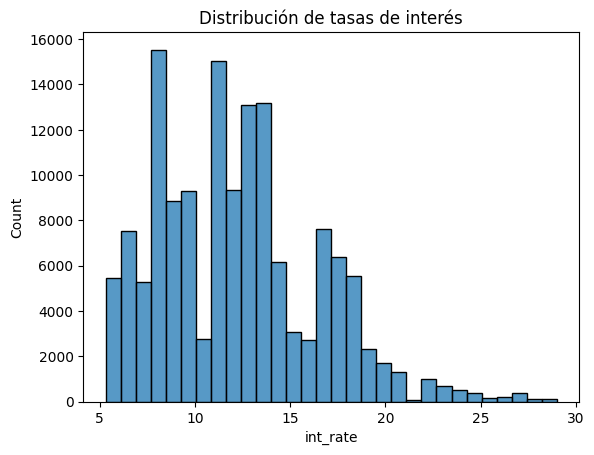

In [61]:
print(f"Total de créditos: {len(df)}")
print(f"Total recomendados: {len(creditos_recomendados)}")
print(df['int_rate'].describe())
sns.histplot(df['int_rate'], bins=30)
plt.title("Distribución de tasas de interés")
plt.show()


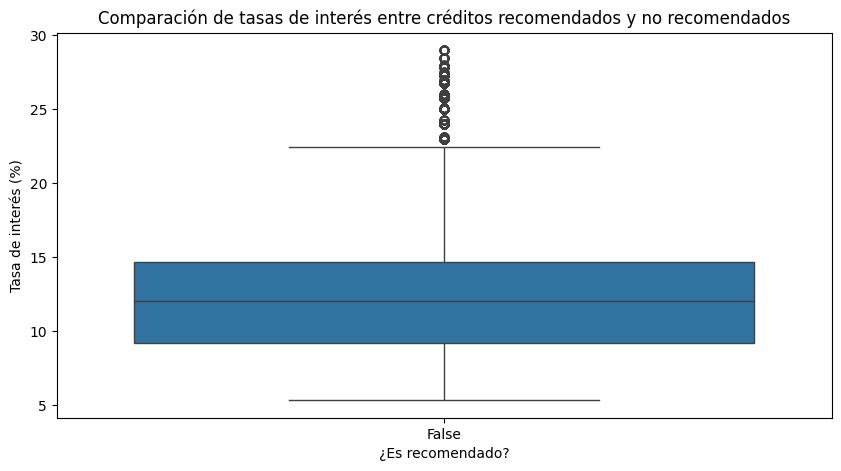

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Comparar tasas de interés de créditos recomendados vs no recomendados
df['es_recomendado'] = df.index.isin(creditos_recomendados.index)

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='es_recomendado', y='int_rate')
plt.title("Comparación de tasas de interés entre créditos recomendados y no recomendados")
plt.xlabel("¿Es recomendado?")
plt.ylabel("Tasa de interés (%)")
plt.show()


Construya al menos 3 atributos derivados que pueden utilizarse para predecir el impago del crédito. Justifique el atributo en términos del negocio. Justifique el nuevo atributo en términos del rendimiento del modelo.

In [35]:
# Atributo 1: Ingreso mensual
df['ingreso_mensual'] = df['annual_inc'] / 12
df['cuota_ingreso'] = df['installment'] / df['ingreso_mensual']

# Atributo 2: Relación cuota-ingreso
df['empleo_estable'] = (
    df[['emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
        'emp_length_8 years', 'emp_length_9 years', 'emp_length_10+ years']]
    .sum(axis=1)
    .apply(lambda x: 1 if x >= 1 else 0)
)

# Atributo 3: Promedio Empleo Estable
df['rango_fico_promedio'] = (df['fico_range_low'] + df['fico_range_high']) / 2

# Ver resultados
print("Ingreso mensual promedio:", df['ingreso_mensual'].mean())
print("Cuota ingreso promedio:", df['cuota_ingreso'].mean())
print("Empleo estable promedio:", df['empleo_estable'].mean())



Ingreso mensual promedio: 6564.142425603404
Cuota ingreso promedio: inf
Empleo estable promedio: 0.5656793612467761


¿Cuáles variables debe excluir del análisis porque se consideran fuga de datos?

In [48]:
import pandas as pd

def detectar_fugas_logicas(df, variable_objetivo='retorno_anual', umbral_corr=0.6, verbose=True):
    """
    Detecta variables que podrían representar fugas de datos al tener una correlación alta con la variable objetivo
    y ser lógicamente posteriores (según un conjunto de palabras clave y tipo de datos).
    """
    posibles_fugas = []

    # Solo usamos variables numéricas para la correlación
    df_numerico = df.select_dtypes(include=['number'])

    if variable_objetivo not in df_numerico.columns:
        if verbose:
            print("❌ La variable objetivo no es numérica o no está en el DataFrame.")
        return []

    # Calcular correlación con la variable objetivo
    correlaciones = df_numerico.corr()[variable_objetivo].drop(variable_objetivo)

    for col, corr in correlaciones.items():
        if abs(corr) >= umbral_corr:
            posibles_fugas.append((col, corr))

    if verbose:
        if posibles_fugas:
            print("⚠️ Variables potenciales con fuga (alta correlación con el retorno):")
            for col, corr in posibles_fugas:
                print(f" - {col} (correlación: {corr:.2f})")
        else:
            print("✅ No se detectaron variables numéricas con alta correlación con el retorno.")

    return [col for col, _ in posibles_fugas]


In [49]:
columnas_fuga_avanzado = detectar_fugas_logicas(df, variable_objetivo='retorno_anual')
df_sin_fugas = df.drop(columns=columnas_fuga_avanzado)


⚠️ Variables potenciales con fuga (alta correlación con el retorno):
 - loan_status (correlación: -0.78)
 - retorno (correlación: 0.96)


¿Cuáles variables individuales son particularmente útiles para predecir la variable dependiente del estado del crédito?

In [45]:
from scipy.stats import pointbiserialr

def medir_correlacion_con_binaria(df, target='loan_status_original_Default'):
    correlaciones = {}
    for col in df.columns:
        if col != target and df[col].dtype in ['int64', 'float64']:
            try:
                corr, _ = pointbiserialr(df[target], df[col])
                correlaciones[col] = abs(corr)
            except:
                pass  # Ignora columnas con errores
    return pd.Series(correlaciones).sort_values(ascending=False)


In [46]:
top_variables = medir_correlacion_con_binaria(df)
print(top_variables.head(10))


total_acc          0.007497
mort_acc           0.007152
loan_amnt          0.006002
loan_status        0.005594
int_rate           0.005434
installment        0.005395
revol_util         0.005030
total_pymnt_inv    0.004079
term_years         0.003795
open_acc           0.003685
dtype: float64


/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:4894: RuntimeWarning: invalid value encountered in subtract
  ym = y - ymean


Construya una medida que relacione cada una de las variables independientes con la variable predictora. Considere que la variable a predecir es binaria, Describa la interpretación de la medida.

In [42]:
from scipy.stats import pointbiserialr
import pandas as pd

def medir_correlacion_con_binaria(df, target='default'):
    correlaciones = {}

    for col in df.columns:
        if col == target:
            continue
        if pd.api.types.is_numeric_dtype(df[col]):
            try:
                corr, _ = pointbiserialr(df[target], df[col])
                if not pd.isna(corr):
                    correlaciones[col] = float(corr)  # asegurar que es numérico
            except:
                pass  # Ignora errores
    correlaciones = pd.Series(correlaciones)
    correlaciones = correlaciones.sort_values(key=lambda x: abs(x), ascending=False)
    return correlaciones


In [47]:
correlaciones = medir_correlacion_con_binaria(df, target='loan_status_original_Default')
correlaciones.head(10)


,0
total_acc,0.007497
mort_acc,0.007152
loan_amnt,0.006002
loan_status,0.005594
int_rate,0.005434
installment,0.005395
revol_util,0.005030
total_pymnt_inv,0.004079
term_years,0.003795
open_acc,0.003685
